In [1]:
%load_ext nb_black

import os
import sys

sys.path.append(
    os.path.abspath("/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/codebase")
)
import torch.backends.cudnn as cudnn
import random
import time
from collections import OrderedDict
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.nn.functional import one_hot
import sklearn.metrics as metrics
import utils
from Explainer.loss_F import loss_fn_kd, entropy_loss
from Explainer.models.Gated_Logic_Net import Gated_Logic_Net
from Explainer.models.explainer import Explainer
from Explainer.models.pi import Pi
from dataset.dataset_cubs import Dataset_cub_for_explainer
from dataset.utils_dataset import get_dataset_with_image_and_attributes
from Explainer.loss_F import loss_fn_kd, entropy_loss, Selective_Distillation_Loss
from Explainer.models.concepts import Conceptizator
import Plots.plot_for_paper as plot
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [2]:
device = utils.get_device()
print(f"Device: {device}")

Device: cuda


<IPython.core.display.Javascript object>

In [3]:
lr = 0.01
cov = 0.2
pickle_in = open(
    os.path.join(
        f"/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/explainer/ViT-B_16/lr_{lr}_epochs_500_temperature-lens_6.0_use-concepts-as-pi-input_True_input-size-pi_2048_cov_{cov}_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.99_temperature-KD_10.0_hidden-layers_1_layer_VIT_explainer_init_none",
        "iter1",
        "explainer",
        "test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr)
print(args.cov)

use_concepts_as_pi_input = True
explainer_init = "none"

experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

root = "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/"
experiment = f"explainer/ViT-B_16/{experiment_folder}"
iteration = "iter1"
expert_type = "explainer"
output = "g_outputs"


test_tensor_preds_1 = torch.load(
    os.path.join(
        root, experiment, iteration, expert_type, output, "test_tensor_preds.pt"
    )
)

test_tensor_preds_bb_1 = torch.load(
    os.path.join(
        root, experiment, iteration, expert_type, output, "test_tensor_preds_bb.pt"
    )
)

test_tensor_y_1 = torch.load(
    os.path.join(root, experiment, iteration, expert_type, output, "test_tensor_y.pt")
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_1.size())
print(test_tensor_preds_bb_1.size())
print(test_tensor_y_1.size())

########################
[0.01]
[0.2]


 << Test sizes >>
torch.Size([1436, 50])
torch.Size([1436, 50])
torch.Size([1436])


<IPython.core.display.Javascript object>

In [4]:
base_lr = 0.01
base_cov = 0.2
pickle_in = open(
    os.path.join(
        f"/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/explainer/ViT-B_16/lr_{base_lr}_epochs_500_temperature-lens_6.0_use-concepts-as-pi-input_True_input-size-pi_2048_cov_{base_cov}_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.99_temperature-KD_10.0_hidden-layers_1_layer_VIT_explainer_init_none",
        "cov_0.2_lr_0.01",
        "iter2",
        "explainer",
        "test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr[-1])
print(args.cov[-1])

use_concepts_as_pi_input = True
explainer_init = "none"

experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

root = "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/"
experiment = f"explainer/ViT-B_16/{experiment_folder}"
iteration = "iter2"
expert_type = "explainer"
output = "g_outputs"


test_tensor_preds_2 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds.pt",
    )
)

test_tensor_preds_bb_2 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds_bb.pt",
    )
)

test_tensor_y_2 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_y.pt",
    )
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_2.size())
print(test_tensor_preds_bb_2.size())
print(test_tensor_y_2.size())


########################
0.01
0.2


 << Test sizes >>
torch.Size([1643, 50])
torch.Size([1643, 50])
torch.Size([1643])


<IPython.core.display.Javascript object>

In [5]:
base_lr = 0.01
base_cov = 0.2
pickle_in = open(
    os.path.join(
        f"/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/explainer/ViT-B_16/lr_{base_lr}_epochs_500_temperature-lens_6.0_use-concepts-as-pi-input_True_input-size-pi_2048_cov_{base_cov}_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.99_temperature-KD_10.0_hidden-layers_1_layer_VIT_explainer_init_none",
        "cov_0.2_lr_0.01",
        "iter3",
        "explainer",
        "test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr[-1])
print(args.cov[-1])

use_concepts_as_pi_input = True
explainer_init = "none"

experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

root = "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/"
experiment = f"explainer/ViT-B_16/{experiment_folder}"
iteration = "iter3"
expert_type = "explainer"
output = "g_outputs"


test_tensor_preds_3 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds.pt",
    )
)

test_tensor_preds_bb_3 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds_bb.pt",
    )
)

test_tensor_y_3 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_y.pt",
    )
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_3.size())
print(test_tensor_preds_bb_3.size())
print(test_tensor_y_3.size())


########################
0.01
0.2


 << Test sizes >>
torch.Size([1432, 50])
torch.Size([1432, 50])
torch.Size([1432])


<IPython.core.display.Javascript object>

In [6]:
base_lr = 0.01
base_cov = 0.2
pickle_in = open(
    os.path.join(
        f"/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/explainer/ViT-B_16/lr_{base_lr}_epochs_500_temperature-lens_6.0_use-concepts-as-pi-input_True_input-size-pi_2048_cov_{base_cov}_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.99_temperature-KD_10.0_hidden-layers_1_layer_VIT_explainer_init_none",
        "cov_0.2_lr_0.01",
        "iter4",
        "explainer",
        "test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr[-1])
print(args.cov[-1])

use_concepts_as_pi_input = True
explainer_init = "none"

experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

root = "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/"
experiment = f"explainer/ViT-B_16/{experiment_folder}"
iteration = "iter4"
expert_type = "explainer"
output = "g_outputs"


test_tensor_preds_4 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds.pt",
    )
)

test_tensor_preds_bb_4 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds_bb.pt",
    )
)

test_tensor_y_4 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_y.pt",
    )
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_4.size())
print(test_tensor_preds_bb_4.size())
print(test_tensor_y_4.size())


########################
0.01
0.2


 << Test sizes >>
torch.Size([1002, 50])
torch.Size([1002, 50])
torch.Size([1002])


<IPython.core.display.Javascript object>

In [7]:
base_lr = 0.01
base_cov = 0.2
pickle_in = open(
    os.path.join(
        f"/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/explainer/ViT-B_16/lr_{base_lr}_epochs_500_temperature-lens_6.0_use-concepts-as-pi-input_True_input-size-pi_2048_cov_{base_cov}_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.99_temperature-KD_10.0_hidden-layers_1_layer_VIT_explainer_init_none",
        "cov_0.2_lr_0.01",
        "iter5",
        "explainer",
        "test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr[-1])
print(args.cov[-1])

use_concepts_as_pi_input = True
explainer_init = "none"

experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

root = "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/"
experiment = f"explainer/ViT-B_16/{experiment_folder}"
iteration = "iter5"
expert_type = "explainer"
output = "g_outputs"


test_tensor_preds_5 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds.pt",
    )
)

test_tensor_preds_bb_5 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds_bb.pt",
    )
)

test_tensor_y_5 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_y.pt",
    )
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_5.size())
print(test_tensor_preds_bb_5.size())
print(test_tensor_y_5.size())


########################
0.01
0.2


 << Test sizes >>
torch.Size([918, 50])
torch.Size([918, 50])
torch.Size([918])


<IPython.core.display.Javascript object>

In [8]:
base_lr = 0.01
base_cov = 0.2
pickle_in = open(
    os.path.join(
        f"/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/explainer/ViT-B_16/lr_{base_lr}_epochs_500_temperature-lens_6.0_use-concepts-as-pi-input_True_input-size-pi_2048_cov_{base_cov}_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.99_temperature-KD_10.0_hidden-layers_1_layer_VIT_explainer_init_none",
        "cov_0.2_lr_0.01",
        "iter6",
        "explainer",
        "test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr[-1])
print(args.cov[-1])

use_concepts_as_pi_input = True
explainer_init = "none"

experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

root = "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/"
experiment = f"explainer/ViT-B_16/{experiment_folder}"
iteration = "iter6"
expert_type = "explainer"
output = "g_outputs"


test_tensor_preds_6 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds.pt",
    )
)

test_tensor_preds_bb_6 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds_bb.pt",
    )
)

test_tensor_y_6 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_y.pt",
    )
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_6.size())
print(test_tensor_preds_bb_6.size())
print(test_tensor_y_6.size())


########################
0.01
0.2


 << Test sizes >>
torch.Size([655, 50])
torch.Size([655, 50])
torch.Size([655])


<IPython.core.display.Javascript object>

In [9]:
expert_type = "explainer"
output = "g_outputs"

preds = torch.cat((test_tensor_preds_1, test_tensor_preds_2, test_tensor_preds_3, 
                   test_tensor_preds_4, test_tensor_preds_5, 
                   test_tensor_preds_6
                   
                  ), dim=0)
gt = torch.cat((test_tensor_y_1, test_tensor_y_2, test_tensor_y_3 ,test_tensor_y_4, 
                test_tensor_y_5, test_tensor_y_6
               ), dim=0)
bb = torch.cat((
    test_tensor_preds_bb_1.cpu(), test_tensor_preds_bb_2.cpu(), test_tensor_preds_bb_3.cpu(),
    test_tensor_preds_bb_4.cpu(), 
    test_tensor_preds_bb_5.cpu(), test_tensor_preds_bb_6.cpu()
), 
               dim=0)


<IPython.core.display.Javascript object>

In [10]:
preds_tot_np = preds.argmax(dim=1).numpy()
gt_tot_np = gt.numpy()
bb_tot_np = bb.argmax(dim=1).numpy()
bb_tot_acc = metrics.accuracy_score(gt_tot_np, bb_tot_np)
g_tot_acc = metrics.accuracy_score(gt_tot_np, preds_tot_np)
g_tot_f1 = metrics.f1_score(gt_tot_np, preds_tot_np, average="micro")
g_tot_precision = metrics.precision_score(gt_tot_np, preds_tot_np, average="micro")
g_tot_recall = metrics.recall_score(gt_tot_np, preds_tot_np, average="micro")
bb_tot_recall = metrics.recall_score(gt_tot_np, bb_tot_np, average="micro")
g_tot_cov = preds.size(0) / 7465


print(f"g_tot_acc: {g_tot_acc * 100} (%)")
print(f"bb_tot_acc: {bb_tot_acc * 100} (%)")
print(f"g_tot_f1: {g_tot_f1 * 100} (%)")
print(f"g_tot_precision: {g_tot_precision * 100} (%)")
print(f"g_tot_recall: {g_tot_recall * 100} (%)")
print(f"bb_tot_recall: {bb_tot_recall * 100} (%)")
print(f"total samples covered by g: {preds.size(0)} (out of {7465})")
print(f"total coverage by g: {g_tot_cov}")

g_tot_acc: 97.57267852102738 (%)
bb_tot_acc: 98.33474456675134 (%)
g_tot_f1: 97.57267852102738 (%)
g_tot_precision: 97.57267852102738 (%)
g_tot_recall: 97.57267852102738 (%)
bb_tot_recall: 98.33474456675134 (%)
total samples covered by g: 7086 (out of 7465)
total coverage by g: 0.9492297387809779


<IPython.core.display.Javascript object>

In [11]:
test_tensor_preds_residual = torch.load(
    os.path.join(
        "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/explainer/ViT-B_16/lr_0.01_epochs_500_temperature-lens_6.0_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.99_temperature-KD_10.0_hidden-layers_1_layer_VIT_explainer_init_none/cov_0.2_lr_0.01/iter6/bb/residual_outputs",
        "test_tensor_preds_residual.pt",
    )
)

test_tensor_preds_bb_residual = torch.load(
    os.path.join(
        "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/explainer/ViT-B_16/lr_0.01_epochs_500_temperature-lens_6.0_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.99_temperature-KD_10.0_hidden-layers_1_layer_VIT_explainer_init_none/cov_0.2_lr_0.01/iter6/bb/residual_outputs",
        "test_tensor_preds_bb.pt",
    )
)

test_tensor_y_residual = torch.load(
    os.path.join(
        "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/explainer/ViT-B_16/lr_0.01_epochs_500_temperature-lens_6.0_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.99_temperature-KD_10.0_hidden-layers_1_layer_VIT_explainer_init_none/cov_0.2_lr_0.01/iter6/bb/residual_outputs",
        "test_tensor_y.pt",
    )
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_residual.size())
print(test_tensor_preds_bb_residual.size())
print(test_tensor_y_residual.size())




 << Test sizes >>
torch.Size([379, 50])
torch.Size([379, 50])
torch.Size([379])


<IPython.core.display.Javascript object>

In [12]:
torch.sum(
    test_tensor_preds_residual.argmax(dim=1) == test_tensor_y_residual
) / test_tensor_preds_residual.size(0)

tensor(0.9657)

<IPython.core.display.Javascript object>

In [13]:
expert_type = "explainer"
output = "g_outputs"

preds = torch.cat((test_tensor_preds_1, test_tensor_preds_2, test_tensor_preds_3, 
                   test_tensor_preds_4, test_tensor_preds_5, test_tensor_preds_6,
                     test_tensor_preds_residual,
#                    test_tensor_preds_7, test_tensor_preds_8
                  ), dim=0)
gt = torch.cat((test_tensor_y_1, test_tensor_y_2, test_tensor_y_3 ,
                test_tensor_y_4, test_tensor_y_5, test_tensor_y_6,
                test_tensor_y_residual
#                test_tensor_y_7, test_tensor_y_8
               ), dim=0)
bb = torch.cat((
    test_tensor_preds_bb_1.cpu(), test_tensor_preds_bb_2.cpu(), test_tensor_preds_bb_3.cpu(),
    test_tensor_preds_bb_4.cpu(), test_tensor_preds_bb_5.cpu(), test_tensor_preds_bb_6.cpu(),
    test_tensor_preds_bb_residual.cpu()
#     test_tensor_preds_bb_7.cpu(), test_tensor_preds_bb_8.cpu()
), 
               dim=0)

preds_tot_np = preds.argmax(dim=1).numpy()
gt_tot_np = gt.numpy()
bb_tot_np = bb.argmax(dim=1).numpy()
bb_tot_acc = metrics.accuracy_score(gt_tot_np, bb_tot_np)
g_tot_acc = metrics.accuracy_score(gt_tot_np, preds_tot_np)
g_tot_f1 = metrics.f1_score(gt_tot_np, preds_tot_np, average="micro")
g_tot_precision = metrics.precision_score(gt_tot_np, preds_tot_np, average="micro")
g_tot_recall = metrics.recall_score(gt_tot_np, preds_tot_np, average="micro")
bb_tot_recall = metrics.recall_score(gt_tot_np, bb_tot_np, average="micro")
g_tot_cov = preds.size(0) / 7465


print(f"g_tot_acc: {g_tot_acc * 100} (%)")
print(f"bb_tot_acc: {bb_tot_acc * 100} (%)")
print(f"g_tot_f1: {g_tot_f1 * 100} (%)")
print(f"g_tot_precision: {g_tot_precision * 100} (%)")
print(f"g_tot_recall: {g_tot_recall * 100} (%)")
print(f"bb_tot_recall: {bb_tot_recall * 100} (%)")
print(f"total samples covered by g: {preds.size(0)} (out of {7465})")
print(f"total coverage by g: {g_tot_cov}")


g_tot_acc: 97.52176825184193 (%)
bb_tot_acc: 98.24514400535834 (%)
g_tot_f1: 97.52176825184193 (%)
g_tot_precision: 97.52176825184193 (%)
g_tot_recall: 97.52176825184193 (%)
bb_tot_recall: 98.24514400535834 (%)
total samples covered by g: 7465 (out of 7465)
total coverage by g: 1.0


<IPython.core.display.Javascript object>

In [14]:
(
    (
        torch.sum(test_tensor_preds_1.argmax(dim=1) == test_tensor_y_1)
        / test_tensor_y_1.size(0)
    ).item()
    * (test_tensor_preds_1.size(0) / 7465),
    (
        torch.sum(test_tensor_preds_2.argmax(dim=1) == test_tensor_y_2)
        / test_tensor_y_2.size(0)
    ).item()
    * (test_tensor_preds_2.size(0) / 7465),
    (
        torch.sum(test_tensor_preds_3.argmax(dim=1) == test_tensor_y_3)
        / test_tensor_y_3.size(0)
    ).item()
    * (test_tensor_preds_3.size(0) / 7465),
    (
        torch.sum(test_tensor_preds_4.argmax(dim=1) == test_tensor_y_4)
        / test_tensor_y_4.size(0)
    ).item()
    * (test_tensor_preds_4.size(0) / 7465),
    (
        torch.sum(test_tensor_preds_5.argmax(dim=1) == test_tensor_y_5)
        / test_tensor_y_5.size(0)
    ).item()
    * (test_tensor_preds_5.size(0) / 7465),
    (
        torch.sum(test_tensor_preds_6.argmax(dim=1) == test_tensor_y_6)
        / test_tensor_y_6.size(0)
    ).item()
    * (test_tensor_preds_6.size(0) / 7465),
    (
        torch.sum(test_tensor_preds_residual.argmax(dim=1) == test_tensor_y_residual)
        / test_tensor_preds_residual.size(0)
    ).item()
    * (test_tensor_preds_residual.size(0) / 7465),
)

(0.18995311871839704,
 0.21219022757880893,
 0.18258540280617408,
 0.1338245158856616,
 0.1209644974595496,
 0.08667112965753074,
 0.04902880043290401)

<IPython.core.display.Javascript object>

In [15]:
(
    0.18995311871839704
    + 0.21219022757880893
    + 0.18258540280617408
    + 0.1338245158856616
    + 0.1209644974595496
    + 0.08667112965753074
    + 0.04902880043290401
)

0.975217692539026

<IPython.core.display.Javascript object>

In [16]:
expert_1_gt, expert_1_correct_pred = plot.create_data_for_expert_label_plot(
    GT_tensor=test_tensor_y_1, pred_tensor=test_tensor_preds_1, n_classes=50
)

expert_2_gt, expert_2_correct_pred = plot.create_data_for_expert_label_plot(
    GT_tensor=test_tensor_y_2, pred_tensor=test_tensor_preds_2, n_classes=50
)
expert_3_gt, expert_3_correct_pred = plot.create_data_for_expert_label_plot(
    GT_tensor=test_tensor_y_3, pred_tensor=test_tensor_preds_3, n_classes=50
)
expert_4_gt, expert_4_correct_pred = plot.create_data_for_expert_label_plot(
    GT_tensor=test_tensor_y_4, pred_tensor=test_tensor_preds_4, n_classes=50
)
expert_5_gt, expert_5_correct_pred = plot.create_data_for_expert_label_plot(
    GT_tensor=test_tensor_y_5, pred_tensor=test_tensor_preds_5, n_classes=50
)
expert_6_gt, expert_6_correct_pred = plot.create_data_for_expert_label_plot(
    GT_tensor=test_tensor_y_6, pred_tensor=test_tensor_preds_6, n_classes=50
)
# expert_7_gt, expert_7_correct_pred = plot.create_data_for_expert_label_plot(
#     GT_tensor=test_tensor_y_7, pred_tensor=test_tensor_preds_7, n_classes=200
# )
# expert_8_gt, expert_8_correct_pred = plot.create_data_for_expert_label_plot(
#     GT_tensor=test_tensor_y_8, pred_tensor=test_tensor_preds_8, n_classes=200
# )


expert_1_gt =np.array([expert_1_gt]).T
expert_2_gt =np.array([expert_2_gt]).T
expert_3_gt =np.array([expert_3_gt]).T
expert_4_gt =np.array([expert_4_gt]).T
expert_5_gt =np.array([expert_5_gt]).T
expert_6_gt =np.array([expert_6_gt]).T
# expert_7_gt =np.array([expert_7_gt]).T
# expert_8_gt =np.array([expert_8_gt]).T

expert_gt = np.concatenate(
    (
        expert_1_gt, 
        expert_2_gt,
        expert_3_gt,
        expert_4_gt,
        expert_5_gt,
        expert_6_gt,
#         expert_7_gt,
#         expert_8_gt
    ), axis=1)

expert_1_correct_pred =np.array([expert_1_correct_pred]).T
expert_2_correct_pred =np.array([expert_2_correct_pred]).T
expert_3_correct_pred =np.array([expert_3_correct_pred]).T
expert_4_correct_pred =np.array([expert_4_correct_pred]).T
expert_5_correct_pred =np.array([expert_5_correct_pred]).T
expert_6_correct_pred =np.array([expert_6_correct_pred]).T
# expert_7_correct_pred =np.array([expert_7_correct_pred]).T
# expert_8_correct_pred =np.array([expert_8_correct_pred]).T

expert_correct_preds = np.concatenate(
    (
        expert_1_correct_pred, 
        expert_2_correct_pred,
        expert_3_correct_pred,
        expert_4_correct_pred,
        expert_5_correct_pred,
        expert_6_correct_pred,
#         expert_7_correct_pred,
#         expert_8_correct_pred
    ), axis=1)
print(expert_gt.shape)
print(expert_correct_preds.shape)






# print(exper_gt.shape)
# print(expert_correct_preds.shape)



(50, 6)
(50, 6)


<IPython.core.display.Javascript object>

In [17]:
order = np.lexsort(
    [
        expert_gt[:, 0],
        expert_gt[:, 1],
        expert_gt[:, 2],
        expert_gt[:, 3],
        expert_gt[:, 4],
        expert_gt[:, 5],
#         expert_gt[:, 6],
#         expert_gt[:, 7],
    ]
)
print(order)
print(len(order))
sorted_cols = []
for idx in order:
    sorted_cols.append(args.labels[idx])
# print(args.labels)
# print(sorted_cols)
expert_gt[order]


[13 25 19 26 46 49  2  8  9 17  5 14 41 23  0 39 27 47 20  1 44 36 30  3
 10 12 28 37 24 15 32  6  4 38 45  7 18 16 40 21 35 31 48 29 11 43 34 33
 42 22]
50


array([[  0,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0],
       [174,   0,   0,   0,   0,   0],
       [240,   0,   0,   0,   0,   0],
       [ 42,   1,   0,   0,   0,   0],
       [188,   1,   0,   0,   0,   0],
       [ 56,   2,   0,   0,   0,   0],
       [  2,  33,   0,   0,   0,   0],
       [  0,  92,   0,   0,   0,   0],
       [  6, 136,   0,   0,   0,   0],
       [  0, 143,   0,   0,   0,   0],
       [  0, 144,   0,   0,   0,   0],
       [  0, 136,   1,   0,   0,   0],
       [ 43, 154,   1,   0,   0,   0],
       [  0, 208,   1,   0,   0,   0],
       [  0, 268,   1,   0,   0,   0],
       [135,   0,   4,   0,   0,   0],
       [ 92,   0,   6,   0,   0,   0],
       [  1,   0, 145,   0,   0,   0],
       [  0,   0, 170,   0,   0,   0],
       [  0,   1, 173,   0,   0,   0],
       [  0,   0, 179,   0,   0,   0],
       [  0,   0, 240,   0,   0,   0],
       [ 23,   0,   2,  12,   0,   0],
       [  0,   0,   0,  37,   0,   0],
       [  0,   0,   0, 17

<IPython.core.display.Javascript object>

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# print(y_axis_labels)
for idx, label in enumerate(y_axis_labels):
    y_axis_labels[idx] = label.replace("+", " ")
#     print(idx, label)


y_axis_labels = sorted_cols
x_axis_labels = [1, 2, 3, 4, 5, 6]
# for i in range(1, 201):
#     y_axis_labels.append(i)

fig, ax = plt.subplots(figsize=(12, 12))
sns.set(font_scale=1.2)
p = sns.heatmap(
    expert_gt[order],
    xticklabels=x_axis_labels,
    yticklabels=y_axis_labels,
    linewidths=0.1,
    cmap="BuPu",
)
p.set_xlabel("# Experts")
p.set_ylabel("Class Labels")
# p.set_yticklabels(p.get_yticklabels(), rotation=10)
plt.show()

NameError: name 'y_axis_labels' is not defined

<IPython.core.display.Javascript object>

[11 13 22 25 33 34 42 43 46 32 29 47 27 24 19 26  2 49  8 16 35  9  4 40
 41 17  5 14 23 39  0 15 20 21  1 44 36 30 48  3 10 12 28 37  6 31 38 45
  7 18]
50


<Figure size 432x288 with 0 Axes>

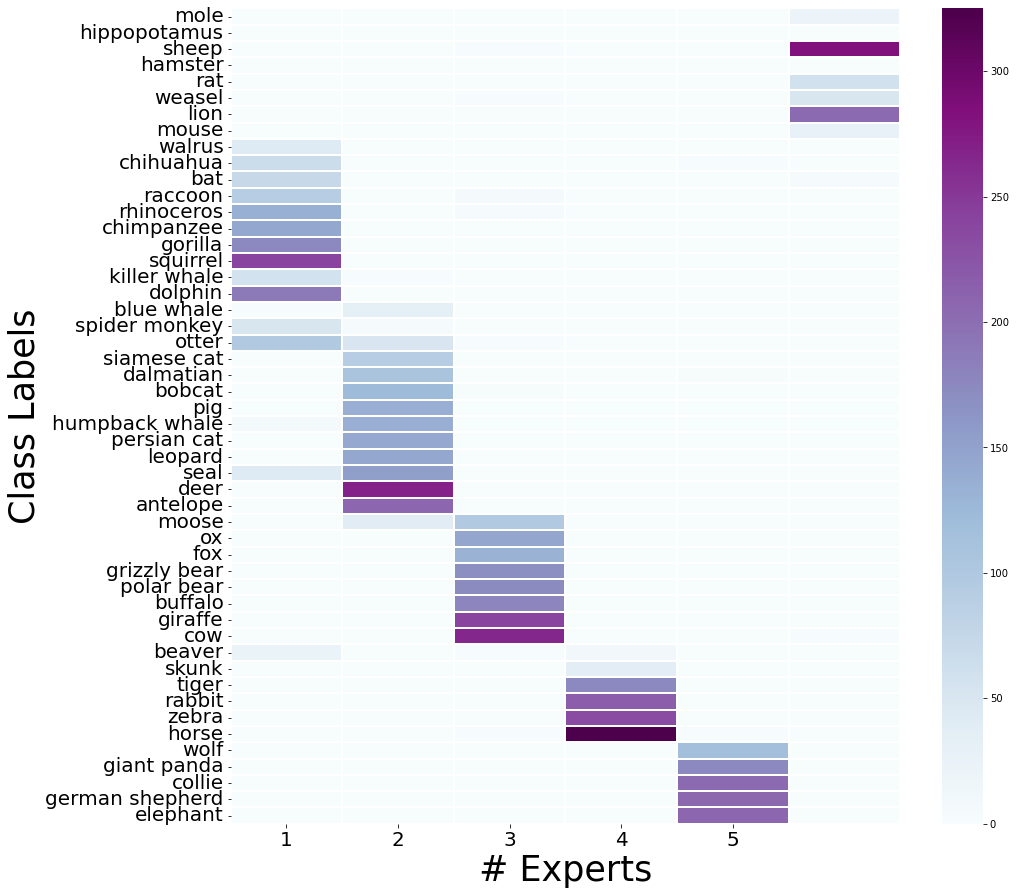

<IPython.core.display.Javascript object>

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

order = np.lexsort(
    [
        expert_correct_preds[:, 0],
        expert_correct_preds[:, 1],
        expert_correct_preds[:, 2],
        expert_correct_preds[:, 3],
        expert_correct_preds[:, 4],
        #         expert_correct_preds[:, 5],
        #         expert_correct_preds[:, 6],
        #         expert_correct_preds[:, 7],
    ],
    axis=0,
)


# print(y_axis_labels)
print(order)
print(len(order))
sorted_cols = []
for idx in order:
    sorted_cols.append(args.labels[idx])
# print(args.labels)
# print(sorted_cols)

plot_folder = "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/Plots/Appendix"

y_axis_labels = sorted_cols
for idx, label in enumerate(y_axis_labels):
    y_axis_labels[idx] = label.replace("+", " ")
# x_axis_labels = [1, 2, 3, 4, 5, ]
x_axis_labels = [
    1,
    2,
    3,
    4,
    5,
]
# for i in range(1, 201):
#     y_axis_labels.append(i)

plt.figure().clear()
plt.close()
plt.cla()
plt.clf()
sns.reset_orig()
fig, ax = plt.subplots(figsize=(15, 15))
# sns.set(font_scale=3)
# p = sns.heatmap(
#     expert_correct_preds[order],
#     xticklabels=x_axis_labels,
#     yticklabels=y_axis_labels,
#     linewidths=0.5,
# )

p = sns.heatmap(
    expert_gt[order],
    xticklabels=x_axis_labels,
    yticklabels=y_axis_labels,
    linewidths=0.1,
    cmap="BuPu",
)
ax.set_xticklabels(x_axis_labels, fontsize=20)
ax.set_yticklabels(y_axis_labels, fontsize=20)
p.set_xlabel("# Experts", fontsize=35)
p.set_ylabel("Class Labels", fontsize=35)

resolution_value = 500
# plt.savefig(
#     os.path.join(plot_folder, "VIT-CUB-performance.png"),
#     format="png",
#     dpi=resolution_value,
#     bbox_inches="tight",
# )
# p.set_yticklabels(p.get_yticklabels(), rotation=10)
plt.show()

In [47]:
for i in test_tensor_preds_3.argmax(dim=1):
    print(i)

tensor(48)
tensor(21)
tensor(1)
tensor(36)
tensor(44)
tensor(48)
tensor(20)
tensor(1)
tensor(1)
tensor(44)
tensor(15)
tensor(44)
tensor(30)
tensor(44)
tensor(30)
tensor(44)
tensor(1)
tensor(1)
tensor(1)
tensor(30)
tensor(36)
tensor(44)
tensor(36)
tensor(44)
tensor(1)
tensor(44)
tensor(20)
tensor(20)
tensor(1)
tensor(36)
tensor(30)
tensor(48)
tensor(48)
tensor(30)
tensor(15)
tensor(15)
tensor(20)
tensor(36)
tensor(48)
tensor(1)
tensor(36)
tensor(44)
tensor(20)
tensor(48)
tensor(36)
tensor(44)
tensor(44)
tensor(48)
tensor(36)
tensor(48)
tensor(1)
tensor(48)
tensor(21)
tensor(1)
tensor(36)
tensor(21)
tensor(48)
tensor(21)
tensor(1)
tensor(21)
tensor(44)
tensor(20)
tensor(30)
tensor(44)
tensor(44)
tensor(30)
tensor(36)
tensor(48)
tensor(36)
tensor(44)
tensor(44)
tensor(36)
tensor(30)
tensor(15)
tensor(44)
tensor(30)
tensor(1)
tensor(48)
tensor(44)
tensor(30)
tensor(48)
tensor(30)
tensor(44)
tensor(30)
tensor(48)
tensor(30)
tensor(21)
tensor(20)
tensor(15)
tensor(36)
tensor(15)
tensor(48)
t

<IPython.core.display.Javascript object>

In [44]:
for i in test_tensor_y_3:
    print(i, args.labels[int(i.item())])

tensor(48.) cow
tensor(21.) fox
tensor(1.) grizzly+bear
tensor(36.) buffalo
tensor(44.) polar+bear
tensor(48.) cow
tensor(20.) ox
tensor(1.) grizzly+bear
tensor(1.) grizzly+bear
tensor(44.) polar+bear
tensor(15.) moose
tensor(44.) polar+bear
tensor(30.) giraffe
tensor(44.) polar+bear
tensor(30.) giraffe
tensor(44.) polar+bear
tensor(1.) grizzly+bear
tensor(1.) grizzly+bear
tensor(1.) grizzly+bear
tensor(30.) giraffe
tensor(36.) buffalo
tensor(44.) polar+bear
tensor(36.) buffalo
tensor(44.) polar+bear
tensor(1.) grizzly+bear
tensor(44.) polar+bear
tensor(20.) ox
tensor(20.) ox
tensor(1.) grizzly+bear
tensor(36.) buffalo
tensor(30.) giraffe
tensor(48.) cow
tensor(48.) cow
tensor(30.) giraffe
tensor(15.) moose
tensor(15.) moose
tensor(27.) rhinoceros
tensor(36.) buffalo
tensor(48.) cow
tensor(1.) grizzly+bear
tensor(24.) chimpanzee
tensor(44.) polar+bear
tensor(20.) ox
tensor(20.) ox
tensor(36.) buffalo
tensor(44.) polar+bear
tensor(44.) polar+bear
tensor(48.) cow
tensor(36.) buffalo
tens

tensor(48.) cow
tensor(30.) giraffe
tensor(48.) cow
tensor(1.) grizzly+bear
tensor(48.) cow
tensor(20.) ox
tensor(20.) ox
tensor(21.) fox
tensor(48.) cow
tensor(1.) grizzly+bear
tensor(30.) giraffe
tensor(1.) grizzly+bear
tensor(48.) cow
tensor(30.) giraffe
tensor(30.) giraffe
tensor(20.) ox
tensor(20.) ox
tensor(20.) ox
tensor(48.) cow
tensor(30.) giraffe
tensor(36.) buffalo
tensor(1.) grizzly+bear
tensor(21.) fox
tensor(1.) grizzly+bear
tensor(1.) grizzly+bear
tensor(44.) polar+bear
tensor(15.) moose
tensor(20.) ox
tensor(48.) cow
tensor(21.) fox
tensor(48.) cow
tensor(30.) giraffe
tensor(30.) giraffe
tensor(48.) cow
tensor(30.) giraffe
tensor(48.) cow
tensor(1.) grizzly+bear
tensor(21.) fox
tensor(21.) fox
tensor(30.) giraffe
tensor(1.) grizzly+bear
tensor(15.) moose
tensor(30.) giraffe
tensor(48.) cow
tensor(48.) cow
tensor(30.) giraffe
tensor(30.) giraffe
tensor(20.) ox
tensor(1.) grizzly+bear
tensor(48.) cow
tensor(30.) giraffe
tensor(48.) cow
tensor(36.) buffalo
tensor(15.) moos

tensor(21.) fox
tensor(15.) moose
tensor(36.) buffalo
tensor(36.) buffalo
tensor(30.) giraffe
tensor(44.) polar+bear
tensor(47.) raccoon
tensor(36.) buffalo
tensor(1.) grizzly+bear
tensor(44.) polar+bear
tensor(36.) buffalo
tensor(48.) cow
tensor(21.) fox
tensor(21.) fox
tensor(1.) grizzly+bear
tensor(48.) cow
tensor(15.) moose
tensor(21.) fox
tensor(15.) moose
tensor(30.) giraffe
tensor(21.) fox
tensor(15.) moose
tensor(44.) polar+bear
tensor(36.) buffalo
tensor(1.) grizzly+bear
tensor(44.) polar+bear
tensor(30.) giraffe
tensor(15.) moose
tensor(1.) grizzly+bear
tensor(44.) polar+bear
tensor(44.) polar+bear
tensor(20.) ox
tensor(20.) ox
tensor(20.) ox
tensor(44.) polar+bear
tensor(20.) ox
tensor(44.) polar+bear
tensor(48.) cow
tensor(48.) cow
tensor(1.) grizzly+bear
tensor(15.) moose
tensor(40.) bobcat
tensor(48.) cow
tensor(44.) polar+bear
tensor(48.) cow
tensor(36.) buffalo
tensor(30.) giraffe
tensor(1.) grizzly+bear
tensor(1.) grizzly+bear
tensor(30.) giraffe
tensor(36.) buffalo
te

<IPython.core.display.Javascript object>